# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import TMVAClassifier

# Directories

In [2]:
track = 'Long'
particle = 'Ghost'

data_path = "/notebooks/data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/" + track

work_path = "/notebooks/mikhail91/PID/mikhail_hushchyn/baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
particle + "/" + track + "/TMVA/kBDT"

netconfig_path = "/notebooks/data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_" + track + "_ANN.txt"

# Read data

In [3]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

pdg = particle_pdg_codes[particle]

In [5]:
filename = data_path + "/data_train.csv"

n = sum(1 for line in open(filename)) - 1
s = n//10
skip = sorted(random.sample(xrange(1,n+1),n-s))

data = pandas.read_csv(filename, skiprows=skip)
data['TrackCloneDist'] *= 1 + 0.00001 * numpy.random.rand(len(data))

labels = (numpy.abs(data.MCParticleType.values) == pdg) * 1.

In [6]:
from sklearn.cross_validation import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3, random_state=42)

In [4]:
netconfig = numpy.loadtxt(netconfig_path, dtype='S', delimiter='\n', comments='!')
features = []
spectator_features = []

for var in netconfig[5:]:
    
    if var.find('#') == -1:
        features.append(var)
    else:
        spectator_features.append(var[1:])

In [8]:
data.shape

(120000, 109)

# Train TMVA BDT

In [9]:
%%time
# Train classifier

tmva_bdt = TMVAClassifier(method='kBDT',
                      features=features,
                      factory_options="V:!Silent:!Color:!DrawProgressBar",
                      H='false',
                      V='true',
                      NTrees=800,
                      VarTransform = "Norm",
                      BoostType = "AdaBoost",
                      PruneMethod = "CostComplexity",
                      PruneStrength = -1,
                      MaxDepth = 3,
                      PruningValFraction = 0.3)


tmva_bdt.fit(data_train, labels_train)

CPU times: user 4.55 s, sys: 494 ms, total: 5.04 s
Wall time: 7min 1s


In [10]:
# Save classifier
import os
if not os.path.exists(work_path):
    os.makedirs(work_path)

# clf_pickle = open(work_path + '/classifier.pkl', 'wb')
# pickle.dump(tmva_bdt, clf_pickle)
# clf_pickle.close()

In [5]:
# Read classifier
clf_pickle2 = open(work_path + '/classifier.pkl', 'rb')
tmva_bdt = pickle.load(clf_pickle2)
clf_pickle2.close()

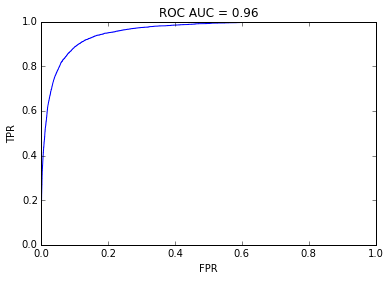

In [12]:
prob_bdt = tmva_bdt.predict_proba(data_test)

roc_auc = roc_auc_score(labels_test, prob_bdt[:, 1])
fpr, tpr, _ = roc_curve(labels_test, prob_bdt[:, 1])

plt.plot(fpr, tpr)
plt.title("ROC AUC = %.2f" % roc_auc)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig(work_path + "/roc_auc.pdf")
plt.show()

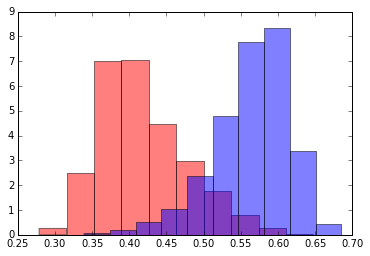

In [13]:
plt.hist(prob_bdt[labels_test==0, 1], color='r', normed=True, alpha=0.5)
plt.hist(prob_bdt[labels_test==1, 1], color='b', normed=True, alpha=0.5)
plt.show()

# Read eval data

In [6]:
filename = data_path + "/data_eval.csv"

n = sum(1 for line in open(filename)) - 1
s = n//10
skip = sorted(random.sample(xrange(1,n+1),n-s))

data_eval = pandas.read_csv(filename, skiprows=skip)

labels_eval = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

# Evaluation

In [7]:
import os, sys
sys.path.append('src')

from get_figures import all_figures

In [8]:
params = {}
params['PARTICLE'] = particle
params['TRACK'] = track

proba_eval = tmva_bdt.predict_proba(data_eval)

In [9]:
%%time
all_figures(params, data_eval, proba_eval, labels_eval, features, path= work_path + "/pic")

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


CPU times: user 23min 2s, sys: 6min 48s, total: 29min 51s
Wall time: 25min 46s


/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


1